[View in Colaboratory](https://colab.research.google.com/github/mzhang32/nanohub-project/blob/master/first_submodel.ipynb)

#First Submodel
Refer to the design document [here](https://docs.google.com/document/d/1BM18EP8cWlJ371yYBoru_q8MHjesn3eBKg7CYRqPmv0/edit). We're using GitHub to back up and Google Drive to collaborate. I believe this tool(Google Colab) will be useful because it is highly collaborative and easy to use.

In [1]:
 !pip install shapely

    100% |████████████████████████████████| 1.5MB 6.5MB/s 


In [7]:
!pip install scipy

In [0]:
import numpy as np
import math
import scipy
from scipy.linalg import *

###Write a function that finds the minimum distance between a pair of 3D line segments.

In [0]:
"""Distance returns the 3D distance between line1=(start1, end1) and
line2=(start2, end2)."""
def distance(line1, line2):
  P = np.array(line1[0])
  Q = np.array(line1[1])
  R = np.array(line2[0])
  S = np.array(line2[1])
  P1mP0 = Q - P
  Q1mQ0 = S - R
  P0mQ0 = P - R
  a = np.dot(P1mP0, P1mP0)
  b = np.dot(P1mP0, Q1mQ0)
  c = np.dot(Q1mQ0, Q1mQ0)         
  d = np.dot(P1mP0, P0mQ0)
  e= np.dot(Q1mQ0, P0mQ0)
  det = a * c - b * b
  if det > 0:
    bte = b * e
    ctd = c * d
    if bte <= ctd: # s <= 0
      s = 0
      if e <= 0:  # t <= 0
        t = 0
        nd = -d
        if nd >= a:
          s = 1
        elif nd > 0:
          s = nd / a
      elif e < c:  #0 < t < 1 and region 5
        t = e / c
      else: # t >= 1
        t = 1   # region 4
        bmd = b - d
        if bmd >= a:
          s = 1
        elif bmd > 0:
          s = bmd / a
    else: 
      s = bte - ctd
      if s >= det:
        s = 1
        bpe = b + e
        if bpe <= 0: # region 8
          t = 0
          nd = -d
          if nd <= 0:
            s = 0
          elif nd < a:
            s = nd / a
        elif bpe < c: # region 1
          t = bpe / c
        else: # region 2
          t = 1
          bmd = b- d
          if bmd <= 0:
            s = 0
          elif bmd < a:
            s = bmd / a
      else:
        ate = a * e
        btd = b * d
        if ate <= btd: # region 7 
          t = 0
          nd = -d
          if nd <= 0:
            s = 0
          elif nd >= a:
            s = 1
          else:
            s = nd / a
        else: 
          t = ate - btd
          if t >= det: # region 3
            t = 1
            bmd = b - d
            if bmd <= 0:
              s = 0
            elif bmd >= a:
              s = 1
            else:
              s = bmd / a
          else:  # region 0
            s /= det
            t /= det
  else: 
    if e <= 0:
      t = 0
      nd = -d
      if nd <= 0: # region 6
        s = 0
      elif nd >=a: # region 8
        s = 1
      else: # region 7
        s = nd / a
    elif e >= c:
      t = 1
      bmd = b - d
      if bmd <= 0: # reigon 4
        s = 0
      elif bmd >= a: # region 2
        s = 1
      else:  # region 3
        s = bmd / a
    else:       
      """The point (0,e/c) is on the line and domain, so we have one
      point at which R is a minimum."""
      s = 0
      t = e / c

  result_parameter = [s, t]
  result_closest = [P + s * P1mP0, R + t * Q1mQ0]
  diff = result_closest[1] - result_closest[0]
  dist = np.dot(diff, diff)
  dist = math.sqrt(dist)
  
  return dist
  



###Given a set of inputs about angle distribution and nanotube length and filament size, generate some line segments .


In [0]:
import numpy as np
import math

"""Returns volume of polymer given width(of square side) and length."""
def calc_volume(width_of_poly, length_of_poly):
    v = (width_of_poly ** 2) * length_of_poly
    return v

"""Returns True if the line (point1, point2) is greater than or 
   equal to diameter distance away from all the lines defined by
   start_points, end_points."""  
def dist_3D(start_points, end_points, point1, point2, diameter):
    for start, end in zip(start_points, end_points):
        dist = distance((start, end), (point1, point2))
        if dist < diameter:
            return False
    return True

"""Returns volume of cylindrical nanowire with diameter and length."""
def wire_volume(length, diameter):
    volume = math.pi * ((diameter / 2) ** 2) * length
    return volume  

def execute(volume_fraction, width_of_poly, length_of_poly, diameter, 
            volume_of_poly, mean_nanowire_length, SD, theta_lower, 
            theta_upper, phi_lower, phi_upper):

    # Creating a list of random starting points for number of desired 
    # nanowires in sim
    def get_initial_point():
        x = np.random.uniform(-(width_of_poly / 2), (width_of_poly / 2))
        y = np.random.uniform(0, length_of_poly)
        z = np.random.uniform(0, width_of_poly)
        g = [x, y, z]
        nonlocal start_points
        start_points.append(g)
        
    # Creating lists of random lengths and angles     
    def lengths_angles(theta_lower, theta_upper, phi_lower, phi_upper):
        length = np.random.normal(mean_nanowire_length, SD)
        lengths.append(length)
        horiz_angle = np.random.uniform(theta_lower, theta_upper)
        verti_angle = np.random.uniform(phi_lower, phi_upper)
        a = [horiz_angle, verti_angle]
        angles.append(a)
        
    # Creating list of respective end points using initial points, 
    # lengths & angles      
    def get_end_points(start_points, lengths, angles, width_of_poly, 
                       length_of_poly, diameter, intersect = True):
        nonlocal wires
        x = start_points[wires][0]
        y = start_points[wires][1]
        z = start_points[wires][2]        
        phi = angles[wires][0]
        theta = angles[wires][1]
        length = lengths[wires]
        x1 = x + length * math.sin(theta) * math.cos(phi)
        y1 = y + length * math.sin(theta) * math.sin(phi)
        z1 = z + length * math.cos(theta)
        point1 = [x, y, x]
        point2 = [x1, y1, z1]
        # Checks to make sure no internal creation
        if intersect == True: 
          if len(end_points) != 0:
              while dist_3D(start_points, end_points, 
                                   point1, point2, diameter) == False:
                  x = np.random.uniform(-(width_of_poly / 2), 
                                        (width_of_poly / 2))
                  y = np.random.uniform(0, length_of_poly)
                  z = np.random.uniform(0, width_of_poly)
                  g = [x, y, z]
                  start_points[wires] = g
                  x1 = x + length * math.sin(theta) * math.cos(phi)
                  y1 = y + length * math.sin(theta) * math.sin(phi)
                  z1 = z + length * math.cos(theta)      
                  point1 = [x, y, x]
                  point2 = [x1, y1, z1]    
        # Checks to make sure end points are in domain
        while y1 > length_of_poly or z1 > width_of_poly or z1 < 0 \
              or abs(x1) > (width_of_poly / 2):
            x = np.random.uniform(-(width_of_poly / 2), 
                                  (width_of_poly / 2))
            y = np.random.uniform(0, length_of_poly)
            z = np.random.uniform(0, width_of_poly)
            g = [x, y, z]
            start_points[wires] = g
            x1 = x + length * math.sin(theta) * math.cos(phi)
            y1 = y + length * math.sin(theta) * math.sin(phi)
            z1 = z + length * math.cos(theta)
        new = [x1, y1, z1]
        end_points.append(new)
        wires += 1    
        
    wires = 0
    volume = 0
    start_points = []
    lengths = []
    angles = []
    end_points = []
    
    while (volume / volume_of_poly) < volume_fraction:
        get_initial_point()
        lengths_angles(theta_lower, theta_upper, phi_lower, phi_upper)  
        get_end_points(start_points, lengths, angles, width_of_poly, 
                       length_of_poly, diameter)
        volume += wire_volume(lengths[-1], diameter)
        #print(wires)
    
    #print(volume)
    #print(wires)
    return start_points, end_points, lengths


In [0]:
# Generates about 2500 nanowires
volume_fraction = 1/100
width_of_poly = 25
length_of_poly = 25
diameter = 125e-3
volume_of_poly = calc_volume(width_of_poly, length_of_poly)
mean_nanowire_length = 5
SD = 1.5e-3
theta_lower = 0
theta_upper = math.pi
phi_lower = 0
phi_upper = math.pi
cross_sectional_area = (diameter / 2) ** 2 * math.pi
start_points, end_points, lengths = execute(volume_fraction, width_of_poly, 
                                   length_of_poly, diameter, 
                                   volume_of_poly, mean_nanowire_length, 
                                   SD, theta_lower, theta_upper, 
                                   phi_lower, phi_upper)


In [12]:
# Testing distance
l1 = [(0, 0, 0), (1, 0, 0)]
l2 = [(2, 0, 0), (3, 0, 0)]
l3 = [(0, 0, 1), (1, 0, 1)]
l4 = [(0, -1, 0), (1, -1, 0)]
l5 = [(0, 0, 0), (1, 1, 0)]
l6 = [(0, 0, 1), (1, 0, 2)]
print(distance(l1[0], l1[1], l2[0], l2[1]))
print(distance(l1[0], l1[1], l3[0], l3[1]))
print(distance(l1[0], l1[1], l4[0], l4[1]))

# Testing start and end points
distances = []
segments = []
for i in range(len(start_points)):
  for j in range(i):
    start1 = start_points[i]
    end1 = end_points[i]
    start2 = start_points[j]
    end2 = end_points[j]
    d = distance(start1, end1, start2, end2)
    if d < diameter:
      distances.append(d)

print(sorted(distances))      

1.0
1.0
1.0
[4.1760340672782024e-05, 5.096928416923324e-05, 0.00023354519822908667, 0.0004284886323204075, 0.000474864201555446, 0.0006067927635657752, 0.0008698161709718382, 0.0009022642521477121, 0.0010204561998959523, 0.0010891656054324932, 0.0013125593507942392, 0.0014402491083933709, 0.0014484261036344119, 0.0017740120616531138, 0.0018062321483568458, 0.0022732816669513937, 0.0023981341636166, 0.0024679086771422355, 0.002480144930036405, 0.0025449035619736905, 0.0026378072638766114, 0.0027073697128681988, 0.002794058803775986, 0.0029125142553538177, 0.0029810894610662604, 0.003017689841559603, 0.0030577647545407694, 0.003402624620737069, 0.0034443173884220425, 0.003523737541255432, 0.003589455253855448, 0.0035987133018034853, 0.003761847620452537, 0.004088547028967566, 0.004139918008675969, 0.004165529059807819, 0.00426664979390941, 0.004311985424515868, 0.00469449594070234, 0.0047705301924029055, 0.005029585030167977, 0.0051003215755183445, 0.005218436724001549, 0.005480771403744

 ### Graphically visualize the model.
 We may have to import some libraries. A good-looking one is this python wrapper for OpenGL, [PyOpenGL](http://pyopengl.sourceforge.net/).
 
 It turns out using opengl in python notebook is not possible(?).

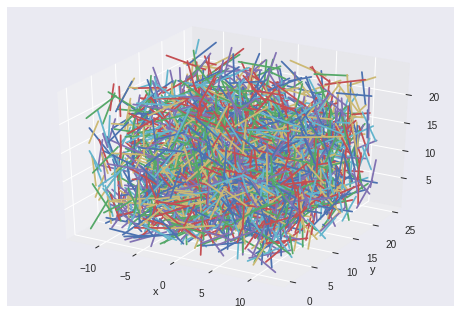

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

segments = []
for start, end in zip(start_points, end_points):
  x = [start[0], end[0]]
  y = [start[1], end[1]]
  z = [start[2], end[2]]
  segments.append([x, y, z])
for seg in segments:
  ax.plot(seg[0], seg[1], seg[2])
plt.xlabel('x')
plt.ylabel('y')  
#ax.plot([0, -1], [0, -1], [0, -1]) # Test line segment
plt.show()  


###Represent the distribution of the nanowires and the distances between them as a graph.
Let G = (V, E) where V is the set of indiviual nanowires and let E = (V1, V2), the distance between nanowires V1 and V2. Using the graph package library [NetworkX](https://networkx.github.io/documentation/stable/tutorial.html).

In [20]:
!pip install networkx

In [0]:
import networkx as nx

""" Returns a networkx graph G formed from V = the segments in format 
 [(x1, x2), (y1, y2), (z1, z2)] and E = distances between the segments 
 that are within tolerance.
"""
def init_graph(segments, tolerance):
  number_of_tubes = len(segments)
  G = nx.Graph()
  # Sort by the one of the segment's endpoint's y value.
  V = sorted(segments, key=lambda v: v[1][0]) 
  line_strings = [[[seg[0][0], seg[1][0], seg[2][0]], 
                   [seg[0][1], seg[1][1], seg[2][1]]] for seg in V]

  G.add_nodes_from(range(number_of_tubes))

  # Generate a graph using distances as weights. Only adds edge if 
  # distance between segments is within tilerance. May need to optimize 
  # later.
  for i in range(number_of_tubes):
    seg1 = V[i]
    line1 = line_strings[i]
    for j in range(i):
      seg2 = V[j]
      line2 = line_strings[j]
      d = distance(line1[0], line1[1], line2[0], line2[1])
      if d <= tolerance:
        G.add_edge(i, j, weight=d)  
  return G
      
  

In [0]:
G = init_graph(segments, diameter)
#G = init_graph(segments, diameter)
#list(G.nodes)

### Use the graph to compute a conductive cluster.
1. Graph theory is great. Details are in the working. The paper used the Union-Find Algorithm :
*"To find the conductive cluster in a nanotube system
between two electrodes and to calculate the probability of
percolation, an algorithm based on the graph theory is used.
According to the algorithm, all tubes of the system are
represented as vertices of a simple graph, edges of which
correspond to the connections between the tubes. Nanotubes
that are in contact with the opposite sides of the parallelepiped
form two subsets corresponding to the electrode. At the next
stage, a component that combines these subsets is sought by
means of the union-find algorithm. Thus, a conductive path in
the nanotubes system is formed.""* From [Computer Simulation of Field-Controlled Percolation
in 3D System of Straight Nanotubes](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8365699&tag=1).

2. Add in model for electrical conductivity of nanowires to calculate material properties in domain.


In [0]:
list(G.edges.data('weight'))

In [0]:
def is_between(b1, x, b2):
   return (b1 <= x and x <= b2) or (b2 <= x and x <= b1)

""" Given the length of the cross-section, a list of sorted segments 
 [(x1, x2), (y1, y2), (z1, z2)], graph G, and a tolerance, return a 
 connecting cluster from source(y~0) to sink(y~length). If none, 
 return None. 
"""
def find_connecting_cluster(length, segs, G, tol):
  source_plane = length/100
  sink_plane = length - length/100
  
  
  n = range(len(segs))
  source_segs = [i for i in n if is_between(segs[i][1][0], 
                                            source_plane, segs[i][1][1])]
  sink_segs = [i for i in n if is_between(segs[i][1][0], 
                                          sink_plane, segs[i][1][1])]
  
  if not source_segs or not sink_segs:
    print("No nanotubes intersecting source and/or sink planes.")
    return None
  
  # Iteratively grow the connecting cluster beginning from the source.
  H = nx.Graph()
  H.add_nodes_from(source_segs)
  new_segs = source_segs
  while new_segs:
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in G.neighbors(seg):
        if v not in sink_segs and v not in H.nodes:
          new_segs.append(v)
        H.add_edge(seg, v, weight=G[seg][v]['weight'])  
  
  # Iteratively grow from the sink to get the final cluster.
  K = nx.Graph()
  new_segs = [v for v in H.nodes if v in sink_segs]
  K.add_nodes_from(new_segs)
  while new_segs:
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in H.neighbors(seg):
        if v not in source_segs and v not in K.nodes:
          new_segs.append(v)
        K.add_edge(seg, v, weight=G[seg][v]['weight'])  
  return K

      
  
  

###Graphically visualize the model with a connecting cluster.

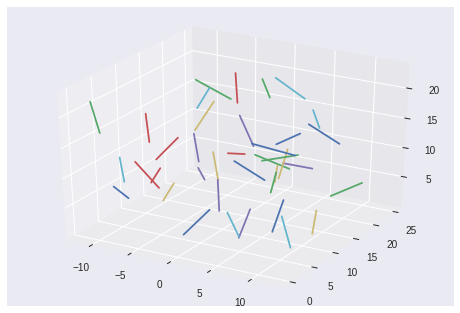

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
K = find_connecting_cluster(length_of_poly, segments, G, diameter)
for n in K.nodes:
  seg = segments[n]
  ax.plot(seg[0], seg[1], seg[2])
plt.show()   

###Closer Examination of Paths

In [0]:
import random

""" Given the length of the cross-section, a list of sorted segments 
 [(x1, x2), (y1, y2), (z1, z2)], graph G, and a tolerance, return some 
 connecting graph. If none, return None. 
"""
def find_connecting_path(length, segs, G, tol):

  source_plane = length/100
  sink_plane = length - length/100

  H = nx.Graph()
  #X = UnionFind()

  def is_between(b1, x, b2):
    return (b1 <= x and x <= b2) or (b2 <= x and x <= b1)
    

  n = range(len(segs))
  source_segs = [i for i in n if is_between(segs[i][1][0], 
                                            source_plane, segs[i][1][1])]
  sink_segs = [i for i in n if is_between(segs[i][1][0], 
                                          sink_plane, segs[i][1][1])]
  #random.shuffle(source_segs)
  #random.shuffle(sink_segs)
  
  print("Source segments: ", source_segs)
  print("Sink segments: ", sink_segs)
  if not source_segs or not sink_segs:
    print("No nanotubes intersecting source and/or sink planes.")
    return None
  
  H.add_nodes_from(source_segs)
  #X.union(source_segs)
  sink = None
  new_segs = source_segs
  while new_segs:
    # Add contacting tubes to each set.  
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in G.neighbors(seg):
        if v not in source_segs:
          #X.union(source_segs[0], v)
          new_segs.append(v)
          H.add_edge(seg, v, weight=G[seg][v]['weight'])
          if v in sink_segs:
            sink = v
            return H, sink, source_segs
            

  
  print("No connecting path found.")
  return None
 
"""Returns a path from source to sink given a graph H. """
def get_paths_from_components(H, sink, source_segs):
  ccs = list(nx.connected_components(H))
  # path = max(ccs, key=lambda c:len(c))
  paths = []
  for component in sorted(ccs, key=lambda c:len(c), reverse=True):
    if sink in component:
      for node in component:
        if node in source_segs and nx.has_path(H, node, sink):
          #p = nx.shortest_path(H, node, sink)
          p = nx.all_simple_paths(H, node, sink)
          paths.extend(p)
          #paths.append(p)
  return paths        
    



In [40]:
H, sink, source_segs = find_connecting_path(length_of_poly, segments, G, diameter)
# Getting a path from the cluster
paths = get_paths_from_components(H, sink, source_segs)
for p in paths:
  print(p)
#print("The path: ", path)

#list(H.edges)


Source segments:  [55, 370, 433, 448, 924, 936, 1057, 1111, 1308, 1470, 1635, 1637, 1685, 1695, 1743, 1753, 1768, 1961, 2018, 2021, 2173, 2245, 2262, 2320, 2372, 2375]
Sink segments:  [198, 273, 372, 382, 426, 539, 642, 664, 796, 896, 907, 948, 1116, 1121, 1285, 1351, 1372, 1384, 1608, 1692, 1722, 1797, 1803, 1850, 1899, 1912, 1954, 2044, 2206, 2207, 2347, 2376, 2401, 2435, 2528]
[1635, 1508, 1460, 1319, 1631, 1692]
[1635, 1646, 1508, 1460, 1319, 1631, 1692]


###Graphically visualize the model with a path.

No handles with labels found to put in legend.


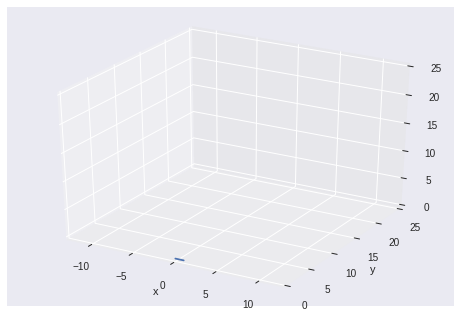

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
path = paths[0]
for n in path:
  seg = segments[n]
#   ax.plot(seg[0], seg[1], seg[2], label=n)
ax.legend()  
ax.plot([0, 1], [0, 0], [0, 0]) # Test line segment
plt.xlabel('x')
plt.ylabel('y')
ax.set_xlim3d(-width_of_poly/2, width_of_poly/2)
ax.set_ylim3d(0, length_of_poly)
ax.set_zlim3d(0, length_of_poly)
plt.show()  


# for i in range(len(path)-1):
#   u = path[i]
#   v = path[i+1]
#   print("Segment %d to %d has weight %f." % (u, v, H.edges[u, v]['weight']))
# print("The path consists of the following segments: ")
# for n in path:
#   print(segments[n])


### Compute conductivity.
Use the equation from this paper: [Conductivity size effect of polycrystalline metal nanowires](https://aip.scitation.org/doi/full/10.1063/1.4967198)

In [0]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, exp, log

# cond_g is the conductivity in presence of both GBS and BS
# lambda_0 is background mean free path
# a is nanowire radius
# p is proportion of elastically scattered electrons
# v is the velocity vector magnitude
# r is the radius vector
# alpha is the 
# d = D is the avg grain diameter
# R is the reflection probability of an electron at a single plane.

def total_conductivity(a, lambda_0, R, d, theta, cond_0, p):
  # C = D/(2*a) = 1
  k = 2*a/lambda_0
  t = 1/sin(theta)
  alpha = (lambda_0/d)*(R/(1-R))
  cond_g = 3*cond_0*(1/3 - .5*alpha + alpha**2 - alpha**3*log(1 + 1/alpha))
  H = 1 + alpha/(1-1/t**2)**.5
  f1 = lambda t : (-1/(H)**2)*(t**-5)*sqrt(t**2 - 1)
  #print('<2>')
  integral_1 = integrate.quad(f1, 1, np.inf) 
  #print('<3>')
  #print(integral_1)
  # Approzimate the geometric series
  def sum_of_series(max):
    total = 0
    for v in range(max):
      f2 = lambda psi : (exp(-(v+1)*H*k*t*sin(psi)) - exp(-v*H*k*t*sin(psi)))*sin(psi)
      integral_2 = integrate.quad(f2, 0, pi/2)
      total = total + p**v * integral_2[0]
    return total
  
  total_cond = cond_g - (12/(pi*k))*(1-p)*integral_1[0]*sum_of_series(10)
  
  return total_cond
  
  

[8.28300045853329, 6.837266230737769, 5.873074944259505, 5.184072730636917, 4.667080810555554, 4.264776205466102, 3.9427639940380415, 3.6791555894879044, 3.459357862271192, 3.273267270801468, 3.113666498041116, 2.9752624259694773, 2.8540848636908933, 2.7470974844070817, 2.6519384462419415, 2.566742919176069, 2.4900188513645882, 2.4205582287069993, 2.357372534627303, 2.299645044998243, 2.246695048134966, 2.1979506509825018, 2.1529278599480786, 2.111214309716738, 2.072456478136048, 2.0363495457732252, 2.002629283111678, 1.9710655075811425, 1.9414567670610912, 1.9136259897310022, 1.8874169013432047, 1.862691056458948, 1.8393253642875265, 1.817210015573455, 1.796246736670417, 1.7763473120899613, 1.7574323285538602, 1.739430102742833, 1.7222757621346643, 1.70591045401808, 1.6902806622977564, 1.6753376153290085, 1.661036770935179, 1.6473373671171427, 1.6342020288789902, 1.6215964231569662, 1.609488955120484, 1.5978505001695762, 1.5866541668260783, 1.5758750864405338, 1.565490226240754, 1.555

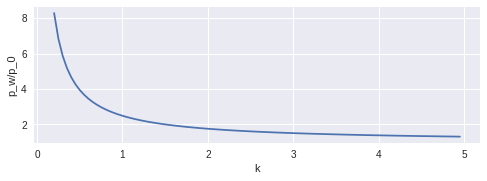

In [38]:
# Using experiment (a) with Ag and R=0.3, p=0.4, C=1
lambda_0 = 125e-9
#cond_0 = 6.3e7 # Silver
C = 1
# Test points for k = 1, 2, 5, 8, 10, 12
#k_list = [.1, .5, 1, 2, 5, 8, 10, 12]
k_list = np.arange(.2, 5, 0.05)
ratio_list = []
for k in k_list:
  a = k*lambda_0*.5
  d = 2*a*C
  #cond_w = total_conductivity(a, lambda_0, .3, d, pi, cond_0, .5)
  cond_0 = 4.1e7 # Gold
  cond_w = total_conductivity(a, lambda_0, .52, d, pi, cond_0, .5)
  ratio_list.append(cond_0/cond_w)
  #print("For k = %.1f we get that p_w/p_0 is %f" % (k, cond_0/cond_w))
print(ratio_list)

# x = np.arange(.1, 25, 0.1)
plt.figure(1)
plt.subplot(211)

plt.plot(k_list, ratio_list)
#plt.axis('square')
plt.xlabel('k')
plt.ylabel('p_w/p_0')
plt.show()

In [61]:
[3.9109067859780144, 3.3370821510976105, 2.9539617838298526, 2.679879869905615, 2.473993311231388, 2.3136044790996517, 2.185089826552471, 2.0797762209083306, 1.9918789083021253, 1.9173910519770736, 1.8534490904261978, 1.7979518878346379, 1.7493226572999607, 1.7063548780589175, 1.6681095493770532, 1.6338448725513637, 1.6029670147524475, 1.574994930025638, 1.5495347666365864, 1.5262609446093178, 1.5049019590630694, 1.4852295869458303, 1.4670505814967014, 1.450200209959396, 1.4345371741160184, 1.4199395801574033, 1.4063017132828635, 1.3935314355061004, 1.3815480704932719, 1.370280672246307, 1.3596665987043195, 1.349650329360915, 1.3401824795166306, 1.3312189740202802, 1.3227203511651968, 1.3146511734170874, 1.3069795263095525, 1.299676590480728, 1.2927162746831204, 1.2860748998595632, 1.279730926177059, 1.2736647163496893, 1.2678583297398884, 1.262295342663922, 1.2569606910885904, 1.2518405325276838, 1.2469221244564987, 1.242193716982655, 1.2376444578588086, 1.2332643082112718, 1.2290439675990192, 1.2249748072186688, 1.2210488102399233, 1.217258518398179, 1.2135969840912264, 1.2100577273288555, 1.2066346969708281, 1.2033222357625388, 1.2001150487408725, 1.1970081746369239, 1.193996959948792, 1.1910770353978035, 1.1882442945161726, 1.185494874144116, 1.1828251366405016, 1.1802316536337605, 1.177711191159547, 1.1752606960488867, 1.1728772834456385, 1.170558225345368, 1.1683009400593316, 1.166102982517538, 1.163962035333874, 1.1618759005642645, 1.1598424920958939, 1.1578598286117745, 1.1559260270805076, 1.1540392967260098, 1.1521979334363974, 1.1504003145751127, 1.148644894160918, 1.146930198386481, 1.1452548214481062, 1.1436174216616677, 1.142016717842073, 1.1404514859256079, 1.138920555816343, 1.1374228084394444, 1.1359571729856963, 1.1345226243329114, 1.1331181806311026, 1.1317429010394064, 1.1303958836037251, 1.1290762632649884, 1.1277832099887342, 1.126515927007468]


    100% |████████████████████████████████| 1.2MB 7.1MB/s 
  Running setup.py bdist_wheel for pyopengl ... - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
Successfully built pyopengl
